# Applying Logistic

In this section we'll see how to apply logistic regression to problems in practice. 

## The Basics
First, we can code the gradient update rule for logistic regression.

In [54]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

# Performs one gradient update step on the weights
def update(theta, X, y, lr):
    grad = - np.dot(X.T, y - sigmoid(np.dot(X, theta)))
    return theta - lr * grad

Let's start with a simple classification problem using some guassian 2D data.

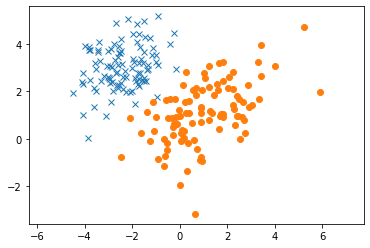

In [55]:
c1_x1, c1_x2 = np.random.multivariate_normal([-2.5,3], [[1, 0.3],[0.3, 1]], 100).T
c2_x1, c2_x2 = np.random.multivariate_normal([1,1], [[2, 1],[1, 2]], 100).T
c1_X = np.vstack((c1_x1, c1_x2)).T
c2_X = np.vstack((c2_x1, c2_x2)).T
X = np.concatenate((c1_X, c2_X))
y = np.concatenate((np.zeros(100), np.ones(100)))
# Shuffle the data
permutation = np.random.permutation(X.shape[0])
X = X[permutation, :]
y = y[permutation]

plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.axis('equal')
plt.show()

Now let's run gradient descent to try and find a model. Note that we can visualize the descision boundary as the point where the output of the model is 0.5, or equal chance between either class. Conveniently, this is also where the output of the linear portion of the model, $\theta^\top x = 0$. So, we can solve for the equation of the decision boundary by solving the previous equation. For 2D data, this works out to be $0 = \theta_1 x_1 + \theta_2 x_2$

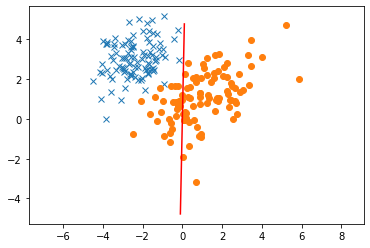

In [59]:
## Model Parameters ###
lr = 0.01
steps = 100

# initialize weights
theta = np.random.normal(0, 0.1, X.shape[1])

# Run gradient descent
for _ in range(steps):
    theta = update(theta, X, y, lr)

# Now let's plot the decision boundary
linex = np.linspace(-0.1, 0.1, 20)
liney = -theta[0] / theta[1] * linex

plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.plot(linex, liney, 'r')
# plt.xlabel('x1')
# plt.ylabel('x2')
plt.axis('equal')
plt.show()

What happened! The decision boundary doesn't look like its accurately modeling the data. Just like in regression, we need to make sure that we have adequate features to model the data. So far, we haven't added a bias, which forces our decision boundary to go through the origin. Let's try adding a bias.

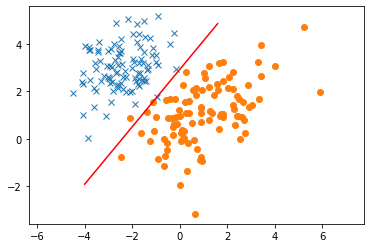

In [60]:
X_add = np.hstack((X, np.ones((X.shape[0], 1))))

## Model Parameters ###
lr = 0.01
steps = 100

# initialize weights
theta = np.random.normal(0, 0.1, X_add.shape[1])

# Run gradient descent
for _ in range(steps):
    theta = update(theta, X_add, y, lr)

# Now let's plot the decision boundary
linex = np.linspace(-4, 1.6, 20)
liney = -theta[0] / theta[1] * linex - theta[2]/theta[1]

plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.plot(linex, liney, 'r')
plt.axis('equal')
plt.show()

Much better!

## Adding Complex Features

Let's try looking at a more complex problem. What if our two data classes are distributed in two different rings.

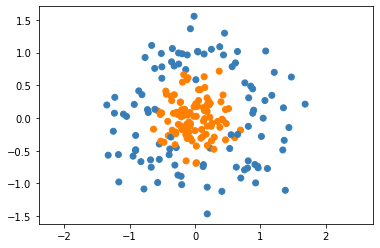

In [61]:
from sklearn.datasets import make_circles
import matplotlib
X, y = make_circles(n_samples=200, noise=0.3, factor=0.1, random_state=1)
cmap = matplotlib.colors.ListedColormap(['#377eb8', '#ff7f00'])

plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap)
plt.axis('equal')
plt.show()

We can try to apply logistic regression as before to this dataset.

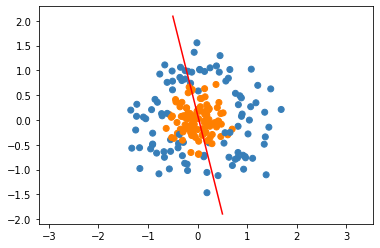

In [62]:
X_add = np.hstack((X, np.ones((X.shape[0], 1))))

## Model Parameters ###
lr = 0.01
steps = 100

# initialize weights
theta = np.random.normal(0, 0.1, X_add.shape[1])

# Run gradient descent
for _ in range(steps):
    theta = update(theta, X_add, y, lr)

# Now let's plot the decision boundary
linex = np.linspace(-0.5, .5, 20)
liney = -theta[0] / theta[1] * linex - theta[2]/theta[1]

plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap)
plt.plot(linex, liney, 'r')
plt.axis('equal')
plt.show()

This is terrible! Let's think about the best way to classify this dataset. Any time of linear boundary is going to do a bad job seperating the data, as the data doesn't seem close to linearly seperable. However, the data does appear to be seperable by circles. Thus, if we add circular features to our dataset, we might be able to get good classification accuracy. Let's try adding the feature $||x||_2$, or the $l2$ norm of the data point. We can visualize this as follows:

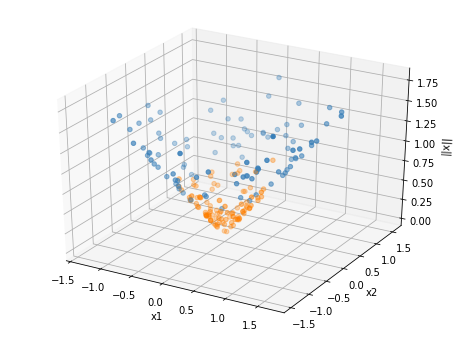

In [78]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], np.sqrt(np.sum(np.square(X), axis=1)), c=y, cmap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('||x||')
plt.show()

Now it looks like we could seperate this data with a plane! If we learn a decision boundary in this 3D space, which would be a plane, and project it down into 2D space, the decision boundary would become a circle! Let's solve for the boundary using logistic regression.

Our decision boundary is given by $0 = \theta_1 x_1 + \theta_2 x_2 + \theta_3 (x_1^2 + x_2^2)^{1/2} + \theta_4$. Using this equation, we can solve for the circle.

However, because the data is centered around the origin, perhaps we can make it even simpler! We don't need to figure out the center of the circle, we just need to figure out the correct radius. Thus, we can actually eliminate the regular linear features, and classify only based on the $l2$ norm. Let's try this and see if it works. Our decision boundary is just $0 = \theta_1 (x_1^2 + x_2^2)^{1/2} + \theta_2$. Note that we still use the bias term to complete the equation of the circle, though one of the parameters is technically redundant and could be fixed. The equation of our decision boundary then becomes $(\theta_2/\theta_1)^2 = x_1^2 + x_2^2$.

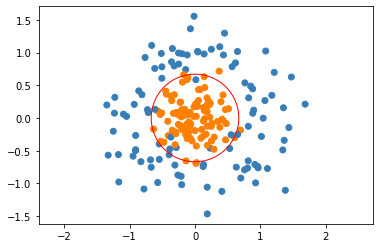

In [77]:
X_circ = np.hstack((np.sqrt(np.sum(np.square(X), axis=1, keepdims=True)), np.ones((X.shape[0], 1))))

## Model Parameters ###
lr = 0.01
steps = 100

# initialize weights
theta = np.random.normal(0, 0.1, X_circ.shape[1])

# Run gradient descent
for _ in range(steps):
    theta = update(theta, X_circ, y, lr)
    
plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap)
boundary = plt.Circle((0,0), abs(theta[1]/theta[0]), color='r', fill=False)
ax = plt.gca()
ax.add_artist(boundary)
plt.axis('equal')

plt.show()


As you can see, we almost completely classify the data correctly using our circular boundary.